In [5]:
%pip install folium

  Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
  Using cached xyzservices-2025.11.0-py3-none-any.whl (93 kB)
  Using cached branca-0.8.2-py3-none-any.whl (26 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import os
import sys
from glob import glob

# 1. Setup Project Path (So we can import from src)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..')) # Adjust if needed
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# 2. Import Custom Modules (The "Senior" Way)
from src.dataprep import io, cleaning

# 3. Setup Thai Fonts for Matplotlib
import matplotlib.font_manager as fm
# Try to find a valid Thai font
found_font = False
for font in ['TH Sarabun New', 'Waree', 'Loma', 'Garuda', 'Noto Sans Thai']:
    if any(f.name == font for f in fm.fontManager.ttflist):
        plt.rcParams['font.family'] = font
        print(f"✅ Loaded Thai Font: {font}")
        found_font = True
        break
if not found_font:
    print("⚠️ No Thai font found. Labels might look like boxes []. Install 'fonts-thai-tlwg'.")

# Style
sns.set_style("whitegrid")

⚠️ No Thai font found. Labels might look like boxes []. Install 'fonts-thai-tlwg'.


In [8]:
def load_spark_csv_output(folder_path):
    """Finds and loads the CSV part file from the Spark output folder."""
    # Spark writes files like 'part-00000-....csv'. We find it with glob.
    files = glob(f"{folder_path}/*.csv")
    if not files:
        raise FileNotFoundError(f"No CSV found in {folder_path}. Did you run the Spark Job?")
    
    print(f"Loading: {files[0]}")
    df = pd.read_csv(files[0])
    
    # Convert date
    df['date'] = pd.to_datetime(df['date'])
    return df

# Load the Data
DATA_PATH = "../data/processed/flood_training_data_csv" # Adjust relative path
df_gold = load_spark_csv_output(DATA_PATH)

print(f"✅ Data Loaded: {df_gold.shape[0]:,} rows")
print(f"Date Range: {df_gold['date'].min().date()} to {df_gold['date'].max().date()}")
df_gold.head()

Loading: ../data/processed/flood_training_data_csv/part-00000-dc12f89c-7065-4d09-a951-dec13b2938ce-c000.csv
✅ Data Loaded: 197,280 rows
Date Range: 2022-01-01 to 2024-12-31


,date,subdistrict,district,latitude,longitude,rainfall,total_report,number_of_report_flood,target,year_timestamp,month_timestamp,month_sin,month_cos,API_30d,API_60d,API_90d
0,2022-01-01,กระทุ่มราย,หนองจอก,13.825804,100.891577,0.0,0,0,0,2022,1,0.5,0.866025,0.0,0.0,0.0
1,2022-01-02,กระทุ่มราย,หนองจอก,13.825804,100.891577,0.0,0,0,0,2022,1,0.5,0.866025,0.0,0.0,0.0
2,2022-01-03,กระทุ่มราย,หนองจอก,13.825804,100.891577,0.0,0,0,0,2022,1,0.5,0.866025,0.0,0.0,0.0
3,2022-01-04,กระทุ่มราย,หนองจอก,13.825804,100.891577,0.0,0,0,0,2022,1,0.5,0.866025,0.0,0.0,0.0
4,2022-01-05,กระทุ่มราย,หนองจอก,13.825804,100.891577,2.5,0,0,0,2022,1,0.5,0.866025,0.5,0.5,0.5


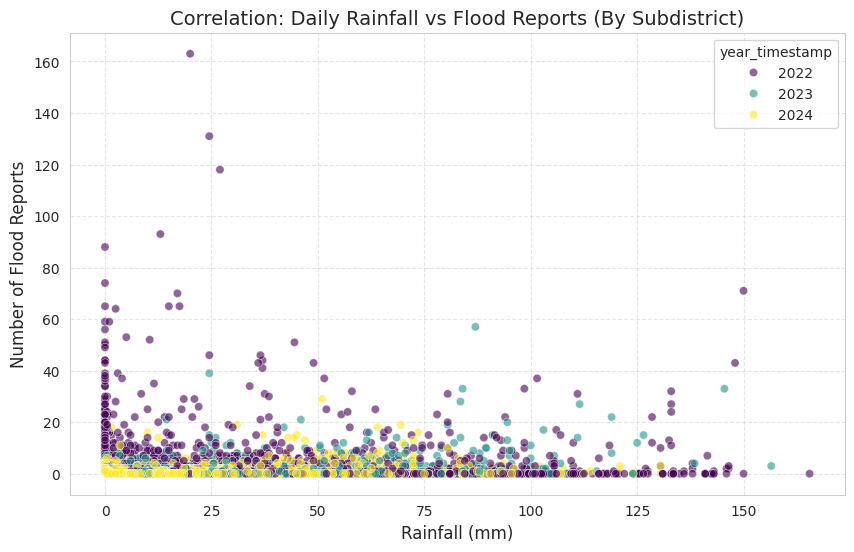

In [9]:
# Filter for days with ANY activity (Rain or Flood) to avoid plotting thousands of (0,0) points
df_active = df_gold[(df_gold['rainfall'] > 0) | (df_gold['number_of_report_flood'] > 0)]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_active,
    x='rainfall',
    y='number_of_report_flood',
    hue='year_timestamp',
    alpha=0.6,
    palette='viridis'
)

plt.title('Correlation: Daily Rainfall vs Flood Reports (By Subdistrict)', fontsize=14)
plt.xlabel('Rainfall (mm)', fontsize=12)
plt.ylabel('Number of Flood Reports', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [10]:
# 1. Load Shapefile using your Module
SHAPE_PATH = "../data/raw/BMA/BMA_ADMIN_SUB_DISTRICT.shp"
gdf = io.load_shapefile(SHAPE_PATH)

# 2. Aggregate Spark Data by Subdistrict (Sum over all 3 years)
flood_counts = df_gold.groupby('subdistrict')['number_of_report_flood'].sum().reset_index()

# 3. Merge Geometry with Data
gdf_merged = gdf.merge(flood_counts, on='subdistrict', how='left')
gdf_merged['number_of_report_flood'] = gdf_merged['number_of_report_flood'].fillna(0)

# 4. Interactive Map (Folium)
m = folium.Map(location=[13.7563, 100.5018], zoom_start=11)

folium.Choropleth(
    geo_data=gdf_merged,
    name='choropleth',
    data=gdf_merged,
    columns=['subdistrict', 'number_of_report_flood'],
    key_on='feature.properties.subdistrict',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Flood Reports (2022-2024)'
).add_to(m)

folium.LayerControl().add_to(m)
m

INFO:src.dataprep.io:Loading Shapefile: ../data/raw/BMA/BMA_ADMIN_SUB_DISTRICT.shp


INFO:src.dataprep.io:Loading CSV: ../data/raw/bangkok_traffy.csv


>>> Loading Raw Data for Text Analysis...


/home/sirav/spark_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3606 (\N{THAI CHARACTER THO THUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sirav/spark_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sirav/spark_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3607 (\N{THAI CHARACTER THO THAHAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sirav/spark_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sirav/spark_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from fon

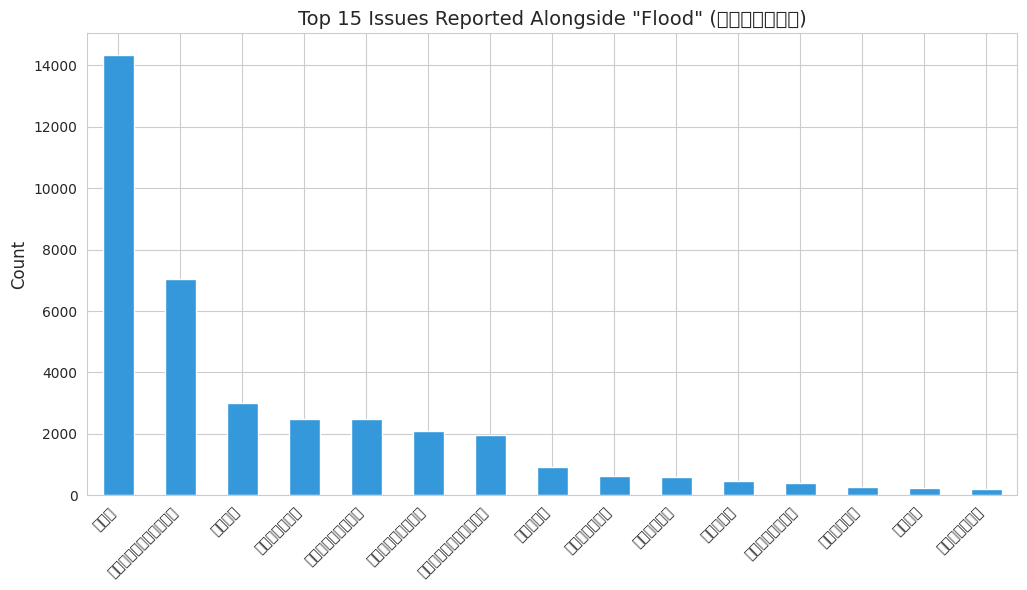

In [11]:
def analyze_cooccurrence(raw_path, target_tag='น้ำท่วม'):
    """
    Analyzes what other tags appear frequently with 'Flood'.
    """
    print(">>> Loading Raw Data for Text Analysis...")
    # Use your custom module to load/clean efficiently
    raw_df = io.load_csv(raw_path)
    df_clean = cleaning.parse_type_column(raw_df) # Extracts 'type_list'
    
    # Filter for rows containing the target tag
    mask = df_clean['type_list'].apply(lambda x: target_tag in x)
    flood_rows = df_clean[mask]
    
    # Count co-occurrences
    co_counts = {}
    for tags in flood_rows['type_list']:
        for tag in tags:
            if tag != target_tag:
                co_counts[tag] = co_counts.get(tag, 0) + 1
                
    return pd.Series(co_counts).sort_values(ascending=False)

# Run Analysis
RAW_PATH = "../data/raw/bangkok_traffy.csv"
co_stats = analyze_cooccurrence(RAW_PATH)

# Plot Top 15
plt.figure(figsize=(12, 6))
co_stats.head(15).plot(kind='bar', color='#3498db')
plt.title('Top 15 Issues Reported Alongside "Flood" (น้ำท่วม)', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

INFO:src.dataprep.io:Loading CSV: ../data/raw/bangkok_traffy.csv


Raw Data: (671916, 19)


INFO:src.dataprep.io:Loading Shapefile: ../data/raw/BMA/BMA_ADMIN_SUB_DISTRICT.shp


Spark Data: (197280, 16)


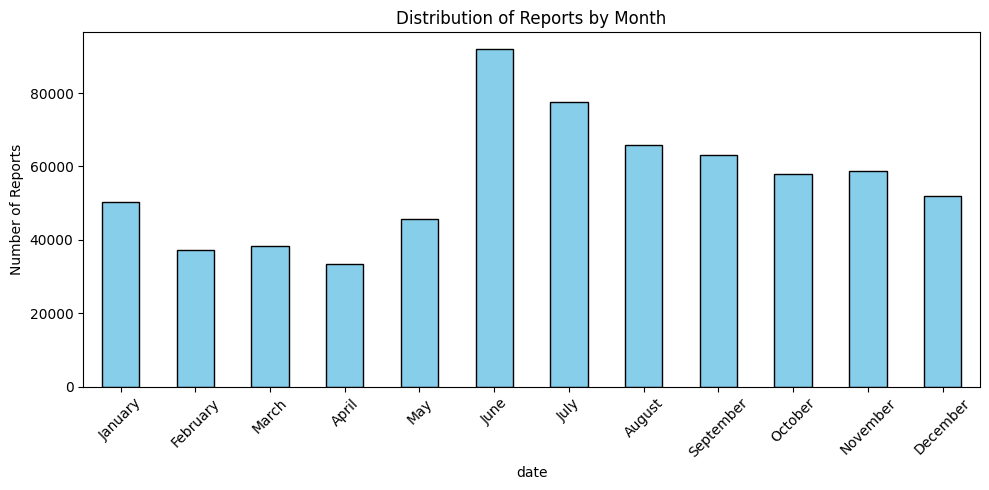

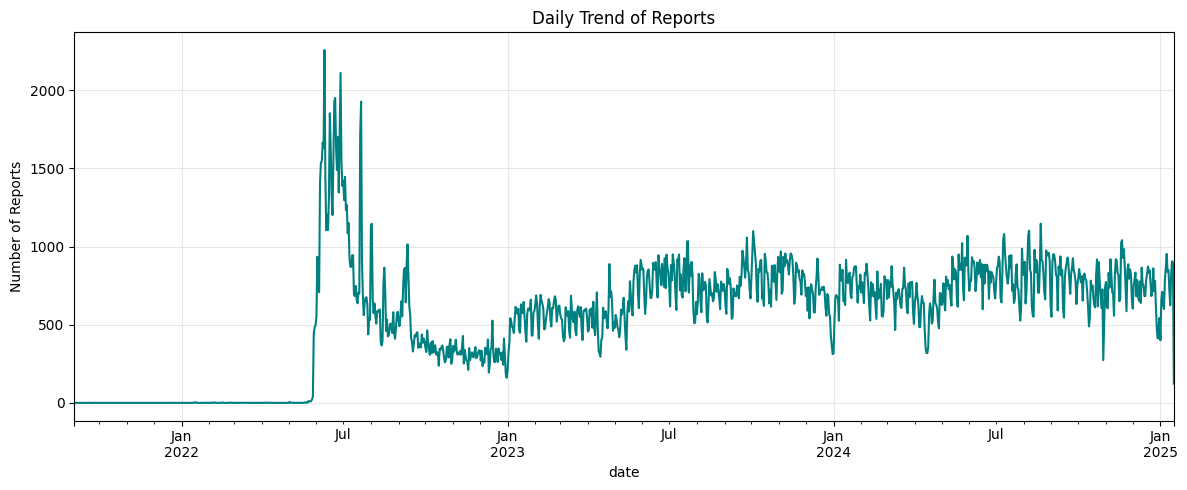

In [ ]:
# %% [markdown]
# # Comprehensive Traffy Fondue Insights
# This notebook reproduces all visualizations using the refactored `src` modules.

# %%
import pandas as pd
import geopandas as gpd
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath('..'))

# Import our new modules
from src.dataprep import io, cleaning
from src.visualization import plots

# Setup Fonts (Run once)
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif' # Fallback
# Uncomment if you have Thai fonts installed
# plt.rcParams['font.family'] = 'TH Sarabun New'

# %% [markdown]
# ## 1. Load Data
# We load BOTH the **Raw Data** (for text/resolution analysis) and **Spark Output** (for aggregated maps).

# %%
# 1. Load Raw (Heavy, but needed for tags/duration)
raw_df = io.load_csv("../data/raw/bangkok_traffy.csv")
raw_df = cleaning.convert_types(raw_df)
raw_df = cleaning.parse_coordinates(raw_df)
# Parse tags for 'Tag Trends' chart
raw_df = cleaning.parse_type_column(raw_df) 

print(f"Raw Data: {raw_df.shape}")

# 2. Load Spark Aggregated (Lightweight, for maps)
spark_df = pd.read_parquet("../data/processed/flood_training_data_spark")
print(f"Spark Data: {spark_df.shape}")

# 3. Load Shapefile
shape_gdf = io.load_shapefile("../data/raw/BMA/BMA_ADMIN_SUB_DISTRICT.shp")

# %% [markdown]
# ## 2. Report Distribution (Static & Interactive)

# %%
# Static
plots.plot_monthly_daily_distribution(raw_df)

# %%
# Interactive (Select Years)
plots.plot_interactive_distribution(raw_df)

# %% [markdown]
# ## 3. Issue Tag Trends
# Which problems happen when? (Explodes the `type` column)

# %%
plots.plot_tag_trends(raw_df)

# %% [markdown]
# ## 4. Resolution Time Analysis
# How long does it take to fix issues?

# %%
plots.plot_resolution_time(raw_df)

# %% [markdown]
# ## 5. Geospatial Analysis
# Using Spark Data for performance.

# %%
# Static Heatmap
m1 = plots.plot_static_heatmap(spark_df)
m1

# %%
# Choropleth with Real Map Background
plots.plot_choropleth_basemap(spark_df, shape_gdf)

# %%
# Animated Time-Series Heatmap
m2 = plots.plot_animated_heatmap(spark_df)
m2

In [4]:
%pip install contextily ipywidgets

  Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
  Using cached widgetsnbextension-4.0.15-py3-none-any.whl (2.2 MB)
  Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl (914 kB)
Note: you may need to restart the kernel to use updated packages.
